# Prediction Ice Cream Sales with Linear Regression



Data set has 2 input features: Temperature in °C and Is Weekend flag (0/1).
Target is called Ice Creams Sold.

Neural network used can only have single input layer and single output layer without activation functions.

## Set up environment

In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.draw_graph import draw_dot
from src.model.builder import build_model
from src.model.training import train_model
from src.model.evaluation import evaluate_model

import random
random.seed(42)

import numpy as np
np.random.seed(42) 

import pandas as pd
from pandas import DataFrame

from matplotlib import pyplot as plt

## Hyperparams

In [2]:
TEST_SIZE = 0.1

# 1e-2 is too high for more than one neuron (exploding gradients)
# 1e-3 makes training too erratic (jumping around minimum)
LEARNING_RATE = 1e-4
BATCH_SIZE = 8
EPOCHS = 1000

EARLY_STOPPING_PATIENCE = 10
EARLY_STOPPING_DELTA = 1e-3

HIDDEN_LAYERS_NUM = 0
HIDDEN_NEURONS_NUM = 0

## Load data

In [3]:
df = pd.read_csv("ice_cream_data.csv", sep=",")
df = df.sample(frac=1, random_state=42)
df.head()

,Temperature,Is_Weekend,Ice_Creams_Sold
110,18.692544,1,203
419,32.571236,0,275
565,27.697531,1,274
77,12.221340,0,104
181,13.404206,0,136


### Separate input from target

In [4]:
targets = df["Ice_Creams_Sold"]
inputs = df.drop(["Ice_Creams_Sold"], axis=1)

In [5]:
inputs.min()

Temperature    10.151848
Is_Weekend      0.000000
dtype: float64

In [6]:
inputs.max()

Temperature    39.99153
Is_Weekend      1.00000
dtype: float64

### Normalize input

In [7]:
def normalize_input(X: DataFrame):
    result = (X - X.min()) / (X.max() - X.min())
    return result

In [8]:
norm_inputs = normalize_input(inputs)

In [9]:
norm_inputs.min()

Temperature    0.0
Is_Weekend     0.0
dtype: float64

In [10]:
norm_inputs.max()

Temperature    1.0
Is_Weekend     1.0
dtype: float64

### Numpy

In [11]:
inputs = norm_inputs.to_numpy()
inputs[:5]

array([[0.2862194 , 1.        ],
       [0.75132798, 0.        ],
       [0.58799831, 1.        ],
       [0.06935369, 0.        ],
       [0.10899439, 0.        ]])

In [12]:
inputs.shape

(600, 2)

In [13]:
targets = targets.to_numpy()
targets[:5]

array([203, 275, 274, 104, 136])

### Train vs. Test set

In [14]:
test_size = int(len(inputs) * TEST_SIZE)
print(f"Train size: {len(inputs) - test_size}, Test size: {test_size}")

inputs_train = inputs[:-test_size]
targets_train = targets[:-test_size]

inputs_test = inputs[-test_size:]
targets_test = targets[-test_size:]

Train size: 540, Test size: 60


## Train Model

In [15]:
n_inputs = inputs.shape[1]
inputs, target, output, loss = build_model(n_inputs, HIDDEN_LAYERS_NUM, HIDDEN_NEURONS_NUM)

In [16]:
history = train_model(inputs_train, inputs_test, targets_train, targets_test, EPOCHS, BATCH_SIZE, LEARNING_RATE, inputs, target, loss, EARLY_STOPPING_PATIENCE, EARLY_STOPPING_DELTA)

Epoch 0: loss=51014.090699646, test_loss=inf
Epoch 1: loss=49050.48382749651, test_loss=56387.56436834401
Epoch 2: loss=47672.20052795178, test_loss=54495.05466111183
Epoch 3: loss=46128.00966180002, test_loss=52748.24214935139
Epoch 4: loss=44411.41336647194, test_loss=51003.868654136895
Epoch 5: loss=42817.69800124122, test_loss=49209.51324936045
Epoch 6: loss=41415.1019901852, test_loss=47585.78471696272
Epoch 7: loss=40141.09586054117, test_loss=46052.45115612268
Epoch 8: loss=38906.89062849532, test_loss=44523.572928323876
Epoch 9: loss=37381.218960040904, test_loss=43017.95072295445
Epoch 10: loss=36049.8525636497, test_loss=41667.95549969245
Epoch 11: loss=35019.67394490868, test_loss=40278.847446021726
Epoch 12: loss=33842.46717928187, test_loss=38942.80588660251
Epoch 13: loss=32769.963370249425, test_loss=37677.555226465236
Epoch 14: loss=31644.18763938617, test_loss=36480.192242585894
Epoch 15: loss=30519.689309353103, test_loss=35283.32624437402
Epoch 16: loss=29463.8946391

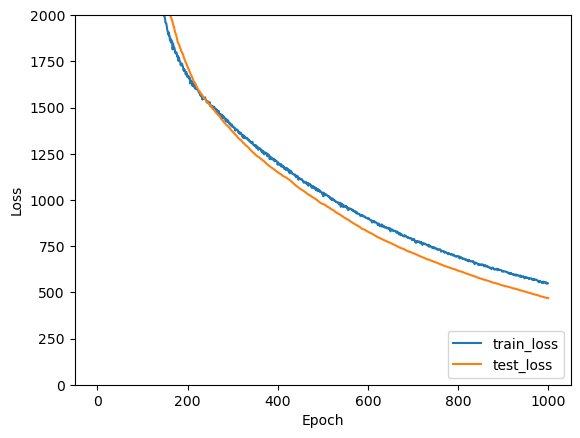

In [17]:
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["test_loss"], label="test_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0, 2000)
plt.legend(loc="lower right")

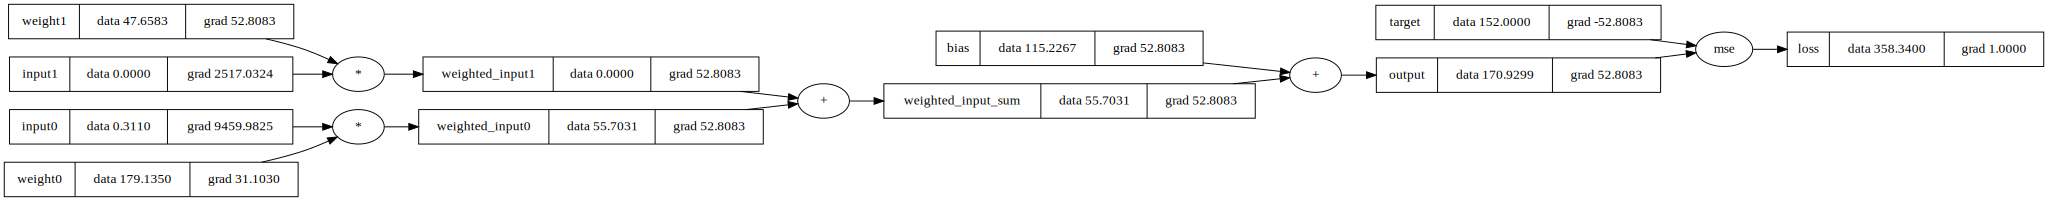

In [18]:
draw_dot(loss)

## Test solution

In [19]:
average_loss = evaluate_model(inputs_test, targets_test, inputs, target, loss)

In [20]:
rmse = np.sqrt(average_loss)
mean_target = np.mean(targets)
print("RMSE:", rmse)
print("Mean of targets:", mean_target)

RMSE: 21.643979697897183
Mean of targets: 216.425
